abrimos el json


In [2]:
# Con estas 2 lineas recargamos automaticamente todos los archivos afiliados al proyecto, sin necesidad de usar el boton de Restart
%load_ext autoreload
%autoreload 2

from modules.open_json import open_json
import folium
 
jsons = list(open_json("../json/mypimes.json"))
geojson = open_json("../json/lha.geojson")
canasta_basica = open_json("../json/canasta_basica.json")


provincia_map = folium.Map(location=(23.133865,-82.3585654))

for i in range(len(jsons)):
        
    folium.Marker(
        location=[jsons[i]["ubicacion"]["lat"], jsons[i]["ubicacion"]["long"]],
        tooltip=f"{jsons[i]["nombre"]}",
        popup= f"<h1>Municipio: {jsons[i]["municipio"]}✅  Horario: {jsons[i]["horario"]} ⏰</h1>",
        icon=folium.Icon(icon="shopping-cart", color="blue")
    ).add_to(provincia_map)
    
folium.GeoJson(geojson,
               style_function= lambda x: {
                   "fillColor": "#93FF69",
                   "color": "#08CB00"
               }
               ).add_to(provincia_map)
folium
    
provincia_map

porciento de bebidas nacionalaes e internacionales que mas se comercializan

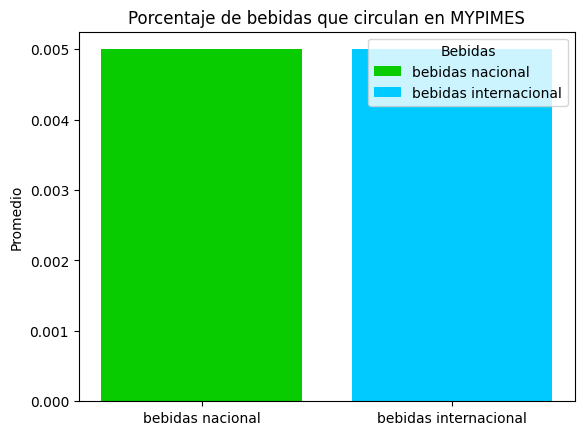

In [3]:

from modules.graphs import porciento
import matplotlib.pyplot as plt

productos = []

for m_productos in jsons:
    productos = m_productos["productos"]

bebida_nacional = []
bebida_internacional = []

for marcas_nacional in productos:
    if marcas_nacional["tipo"] == "bebida":
        
        if marcas_nacional["nacional"] == True:
            bebida_nacional.append(marcas_nacional)
            
        if marcas_nacional["nacional"] == False:            
            bebida_internacional.append(marcas_nacional)

porciento_nacional= porciento(total=len(bebida_internacional) + len(bebida_nacional), parte= len(bebida_nacional))/ 100
porciento_internacional = porciento(total=len(bebida_internacional) + len(bebida_nacional), parte= len(bebida_internacional))/ 100


fig , ax = plt.subplots()

ax.bar(["bebidas nacional", "bebidas internacional"],[porciento_internacional, porciento_nacional], label=["bebidas nacional", "bebidas internacional"], color= ["#08CB00", "#00CAFF"])
ax.set_ylabel("Promedio")
ax.legend(title='Bebidas')
ax.set_title("Porcentaje de bebidas que circulan en MYPIMES")
plt.show()      
        

marcas que mas se comercializan

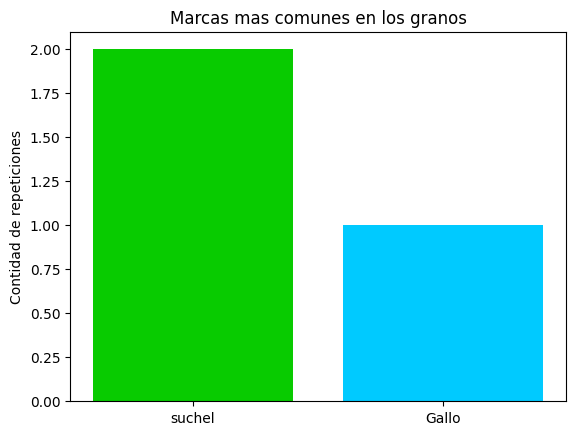

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

marcas_granos = []

for elementos in productos:
    if elementos.get("tipo") == "granos":
        marcas_granos.append(elementos.get("marca"))

contador_marcas = Counter(marcas_granos)


lista_valores = list(contador_marcas.values())
lista_valores

fig = plt.bar(list(contador_marcas.keys()), height= lista_valores, color= ["#08CB00", "#00CAFF"])

plt.title("Marcas mas comunes en los granos")

plt.ylabel("Contidad de repeticiones")
plt.show()


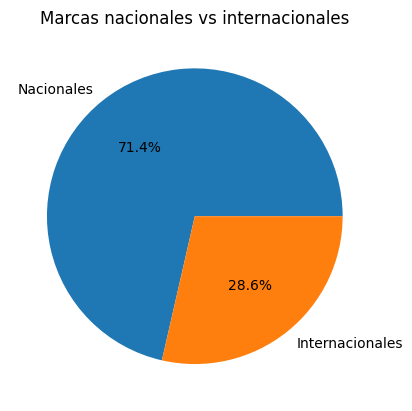

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

marcas_nac = [] 
marcas_int = []

for marcas in productos:
    if marcas.get("nacional") == True:
        marcas_nac.append(marcas.get("marca"))
    else:
        marcas_int.append(marcas.get("marca"))

contador_nac = len(marcas_nac)
contador_int = len(marcas_int)

valores = [contador_nac, contador_int]
labels = ["Nacionales", "Internacionales"]

fig, ax = plt.subplots()
ax.pie(valores, labels=labels, autopct='%1.1f%%')
ax.set_title("Marcas nacionales vs internacionales")

plt.show()


In [ ]:
salario_minimo = 2100
salario_medio = 6506.5

print(canasta_basica)

{'canasta_basica': {'alimentos': {'arroz_nacional': 2.5, 'arroz_importado(15%particulas)': 3.0, 'arroz_importado(4%particulas)': 3.2, 'frijoles_negros_nacionales': 1.8, 'frijol_imoportado': 1.4, 'frijoles_colorados_nacionales': 5.2, 'aceite_vegetal': 1.8, 'aceite_vegetal_soya': 2.3, 'azucar_refino': 5.8, 'azucar_crudo': 2.3, 'cafe_mezclado': 4.1, 'sal_comun': 1.2, 'fideos': 7.8, 'leche': 0.25, 'leche_polvo': 2.5, 'pan': 1.2, 'keroseno': 2.0, 'alcohol': 5.2}, 'productos_de_limpieza': {'jabÃ³n': 0.5, 'jabÃ³n_de_baÃ±o': 2.7, 'detergente': 1.0, 'pasta_de_dientes': 1.2}}}
